In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
class CustomBERT(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased", embedding_dim=32, num_labels=2):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

        for param in self.bert.parameters():
            param.requires_grad = False

        self.projection = nn.Linear(self.bert.config.hidden_size, embedding_dim)  # 768 → 32
        self.classifier = nn.Linear(embedding_dim, num_labels)  # Классификационный слой

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids, attention_mask=attention_mask)

        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, 768)
        projected_embeddings = self.projection(last_hidden_state[:, 0, :])  # Берём [CLS] (batch, 32)
        logits = self.classifier(projected_embeddings)  # (batch, num_labels)

        return logits, projected_embeddings

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = load_dataset("imdb", split="train[:2000]").train_test_split(test_size=0.2)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Убираем лишние колонки
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=8, shuffle=True)
test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBERT(embedding_dim=32).to(device)


optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()  # Функция потерь для классификации

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits, _ = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)  # Берём класс с максимальным значением

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return avg_loss, accuracy, f1

In [ ]:
num_epochs = 2
train_losses = []
val_losses = []
val_accuracies = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits, embeddings = model(input_ids, attention_mask)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    avg_val_loss, val_acc, val_f1 = evaluate_model(model, test_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Эпоха {epoch+1}/{num_epochs}:")
    print(f"  🔹 Train Loss: {avg_train_loss:.4f}")
    print(f"  🔹 Val Loss: {avg_val_loss:.4f}")
    print(f"  🔹 Accuracy: {val_acc:.4f}")
    print(f"  🔹 F1 Score: {val_f1:.4f}")

Эпоха 1/2:
  🔹 Train Loss: 0.1128
  🔹 Val Loss: 0.0156
  🔹 Accuracy: 1.0000
  🔹 F1 Score: 1.0000
Эпоха 2/2:
  🔹 Train Loss: 0.0121
  🔹 Val Loss: 0.0045
  🔹 Accuracy: 1.0000
  🔹 F1 Score: 1.0000


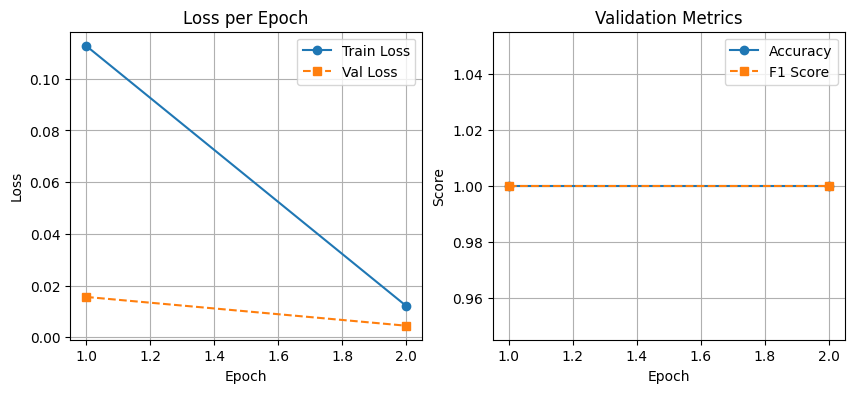

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker="o", linestyle="-", label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, marker="s", linestyle="--", label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker="o", linestyle="-", label="Accuracy")
plt.plot(range(1, num_epochs + 1), val_f1s, marker="s", linestyle="--", label="F1 Score")
plt.title("Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
updated_embeddings = model.projection.weight.detach()
torch.save(updated_embeddings, "bert_embeddings_32.pth")
print("Обновлённые эмбеддинги сохранены в 'bert_embeddings_32.pth'")

loaded_embeddings = torch.load("bert_embeddings_32.pth")
print("Загруженные эмбеддинги:", loaded_embeddings.shape)  # (32, 768)

Обновлённые эмбеддинги сохранены в 'bert_embeddings_32.pth'
Загруженные эмбеддинги: torch.Size([32, 768])


<ipython-input-7-5fa2a06b6695>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_embeddings = torch.load("bert_embeddings_32.pth")


In [13]:
def forward(self, input_ids, attention_mask, token_type_ids=None):
    # Передаём token_type_ids, если он не None
    with torch.no_grad():
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

    last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, 768)
    projected_embeddings = self.projection(last_hidden_state[:, 0, :])  # Берём [CLS] токен
    logits = self.classifier(projected_embeddings)  # (batch_size, num_labels)

    return logits, projected_embeddings

In [14]:
# Текст для инференса
text = "This movie was absolutely fantastic!"

# Токенизация
inputs = tokenizer(
    text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)
inputs = {key: value.to(device) for key, value in inputs.items()}  # Отправляем данные на устройство

# Инференс
model.eval()
with torch.no_grad():
    _, embedding_32 = model(**inputs)  # Получаем эмбеддинг [CLS] токена

# Результат
print(f"Эмбеддинг текста '{text}' (размерности 32):\n", embedding_32.squeeze().cpu().numpy())

TypeError: CustomBERT.forward() got an unexpected keyword argument 'token_type_ids'

In [11]:
# Получаем доступ к предобученным эмбеддингам слов из BERT
word_embeddings = model.bert.embeddings.word_embeddings.weight.detach()

# Проверяем размерность эмбеддингов
print(f"Размерность эмбеддингов слов: {word_embeddings.shape}")  # Ожидается (vocab_size, 768)

# Токен, для которого нужен эмбеддинг
word = "positive"

# Проверяем, есть ли слово в словаре
if word in tokenizer.vocab:
    word_index = tokenizer.vocab[word]  # Получаем индекс слова
    word_embedding = word_embeddings[word_index]  # Извлекаем эмбеддинг
    print(f"Эмбеддинг слова '{word}' (размерности 768):\n", word_embedding.cpu().numpy())
else:
    print(f"Слово '{word}' отсутствует в словаре.")

Размерность эмбеддингов слов: torch.Size([30522, 768])
Эмбеддинг слова 'positive' (размерности 768):
 [-1.86178293e-02  8.03652406e-03 -6.23774640e-02 -2.98537668e-02
 -4.35613655e-02 -5.96193485e-02 -3.07825091e-03 -4.84510288e-02
 -3.26877944e-02  1.15986625e-02 -4.74850051e-02 -1.88706759e-02
 -1.22521020e-01 -5.15133105e-02  2.92325243e-02 -3.49388681e-02
  3.18139158e-02 -2.42586508e-02  7.23700598e-02 -1.00904495e-01
 -2.84108403e-03  1.91621017e-02 -3.59544205e-03  3.44669586e-03
 -6.08289763e-02 -4.10940871e-02 -4.81659099e-02 -5.11342734e-02
 -1.21636810e-02 -7.37024546e-02  5.11636175e-02  5.86839998e-03
  3.26818191e-02 -4.79817912e-02  4.59443554e-02 -4.57939990e-02
 -1.58814248e-02  4.13850974e-03 -1.85108576e-02  4.93412204e-02
 -8.74449033e-03 -3.99737172e-02 -7.76003599e-02  4.61256690e-02
  6.47979081e-02 -4.48342673e-02 -4.12726030e-03 -3.89436185e-02
  3.40127163e-02 -1.17282216e-02 -5.44812456e-02 -6.70193657e-02
 -9.13779959e-02 -5.23898564e-03  3.22483620e-03 -7.4